In [41]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import random
import cv2
from PIL import Image
import math
from scipy.stats import spearmanr
from scipy.ndimage import convolve

from baseline import MultiMethod

import torch
from torchvision import transforms
import torch.nn as nn
from muenn import MueNN
from utils import InputPadder

In [42]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [43]:
# data_path_multimodel = '/home/panding/code/UR/piv-data/unflownet-mm'
# data_path_multitransform = '/home/panding/code/UR/piv-data/unflownet-mt'
# data_path_truth = '/home/panding/code/UR/piv-data/truth'
# data_path_un = '/home/panding/code/UR/piv-data/ur-un'
# data_path_ur = '/home/panding/code/UR/piv-data/raft-test'

data_path_multimodel = '/home/panding/code/UR/piv-data/baseline-multimodel'
data_path_multitransform = '/home/panding/code/UR/piv-data/baseline-multitransform'
data_path_truth = '/home/panding/code/UR/piv-data/truth'
data_path_un = '/home/panding/code/UR/piv-data/raft-test'
data_path_ur = '/home/panding/code/UR/piv-data/raft-test'

def load_data(cls):

    datas_multimodel = glob.glob(os.path.join(data_path_multimodel, cls+'*.npy'))
    datas_multitransform = glob.glob(os.path.join(data_path_multitransform, cls+'*.npy'))
    datas_truth = glob.glob(os.path.join(data_path_truth, cls+'*.npy'))
    # datas_ur = glob.glob(os.path.join(data_path_ur, 'S*.npy'))
    datas_ur_img_1 = glob.glob(os.path.join(data_path_ur, cls+'*img1.tif'))
    datas_ur_img_2 = glob.glob(os.path.join(data_path_ur, cls+'*img2.tif'))
    datas_un = glob.glob(os.path.join(data_path_un, cls+'*.npy'))

    datas_multimodel = sorted(datas_multimodel)
    datas_multitransform = sorted(datas_multitransform)
    datas_truth = sorted(datas_truth)
    datas_un = sorted(datas_un)

    # datas_ur = sorted(datas_ur)
    datas_ur_img_1 = sorted(datas_ur_img_1)
    datas_ur_img_2 = sorted(datas_ur_img_2)
    assert len(datas_multimodel) == len(datas_ur_img_1) == len(datas_ur_img_2)
    
    return datas_multimodel, datas_multitransform, datas_truth, datas_un

def pdf(mu, sigma):
    return (1/sigma*math.sqrt(2*math.pi))*np.exp(-np.square(mu)/(2*np.square(sigma)))

def compute_probability(mms, mts, uns, mm, mt, mue):
    idx_random = random.randint(0, len(uns))
    u_res = np.abs(np.load(uns[idx_random])[-2] - np.load(uns[idx_random])[2])
    v_res = np.abs(np.load(uns[idx_random])[-1] - np.load(uns[idx_random])[3])
    u_mm, v_mm = mm.uncertainty(np.load(mms[idx_random]))
    u_mt, v_mt = mt.uncertainty(np.load(mts[idx_random]))
    data_mue = np.load(uns[idx_random])[:4]
    data_mue = torch.from_numpy(data_mue).to(DEVICE)
    u_mue, v_mue = mue.get_sigma(data_mue)
    
    pdf_mm_2d = np.sqrt(np.square(pdf(u_res, u_mm)) + np.square(pdf(v_res, v_mm)))
    pdf_mt_2d = np.sqrt(np.square(pdf(u_res, u_mt)) + np.square(pdf(v_res, v_mt)))
    pdf_mue_2d = np.sqrt(np.square(pdf(u_res, u_mue)) + np.square(pdf(v_res, v_mue)))
    
    res_2d = np.sqrt(np.square(u_res) + np.square(v_res))
    
    return np.abs(np.stack((pdf_mm_2d, pdf_mt_2d, pdf_mue_2d), 0)), res_2d

def get_probability():
    
    cls = ['backstep', 'cylinder', 'JHTDB_channel', 'JHTDB_isotropic1024_hd', 'JHTDB_mhd1024_hd', 'SQG']
    model_path = '/home/panding/code/UR/unet-model/best-1.pt'
    my_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mue = MueNN(model_path, my_device)
    mm = MultiMethod(0)
    mt = MultiMethod(1)
    cls_random = random.randint(0, len(cls)-1)
    print(cls[cls_random])
    mms, mts, truths, uns = load_data(cls[cls_random])
    result, res_2d = compute_probability(mms, mts, uns, mm, mt, mue)
    
    return result, res_2d

In [44]:
res, res_2d = get_probability()

backstep


2921810.2
2444605.8
4469979.5


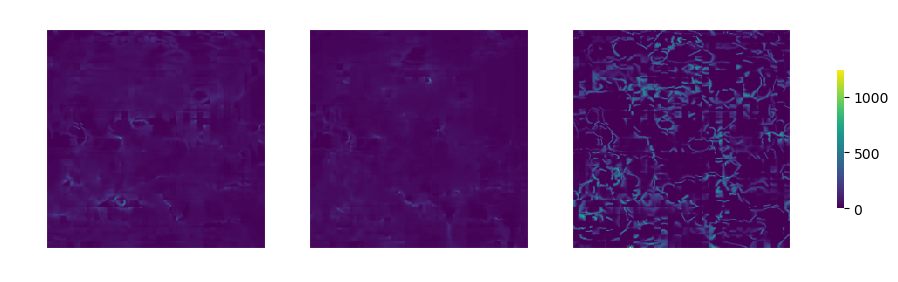

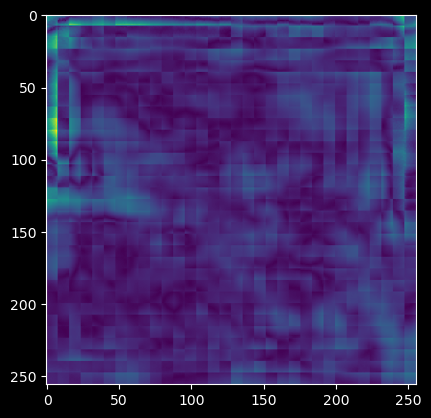

In [45]:
# 创建一个包含3个子图的figure
fig, axs = plt.subplots(1, 3, figsize=(12, 3), facecolor='white')

# 在每个子图中分别呈现一个通道的值
for i in range(3):

    
    im = axs[i].imshow(res[i, :, :], cmap='viridis')
    print(res[i].sum())
        
    axs[i].set_title('Channel {}'.format(i+1))

# 设置子图背景色为白色
fig.patch.set_facecolor('white')

# 调整子图之间的间隔颜色
plt.subplots_adjust(wspace=0.2)  # 设置子图水平间距

# 创建共用的colorbar
cbar = fig.colorbar(im, ax=axs, shrink=0.6, location='right')
cbar.ax.yaxis.set_tick_params(color='black')  # 设置colorbar的字体颜色为黑色
cbar.outline.set_visible(False)  # 去除colorbar的轮廓线
cbar.ax.tick_params(colors='black')

# 展示图像
plt.show()

plt.figure()
plt.imshow(res_2d)
plt.show()

In [46]:
def compute_ssim(original_image, distorted_image, K1=0.01, K2=0.03, L=255):
    original_image = original_image.astype(np.float64)
    distorted_image = distorted_image.astype(np.float64)
    C1 = (K1 * L) ** 2
    C2 = (K2 * L) ** 2

    # 计算亮度
    mu_x = convolve(original_image, weights=np.ones((8, 8))) / 64.0
    mu_y = convolve(distorted_image, weights=np.ones((8, 8))) / 64.0

    # 计算对比度
    sigma_x = np.sqrt(
        (convolve(original_image ** 2, weights=np.ones((8, 8))) / 64.0) - mu_x ** 2)
    sigma_y = np.sqrt(
        (convolve(distorted_image ** 2, weights=np.ones((8, 8))) / 64.0) - mu_y ** 2)
    sigma_xy = (convolve(original_image * distorted_image, weights=np.ones((8, 8))) / 64.0) - mu_x * mu_y

    # 计算结构相似性度量
    ssim_map = ((2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)) / ((mu_x ** 2 + mu_y ** 2))
    
    return(np.mean(ssim_map))

In [47]:
def ssim(img1, img2):
    C1 = (0.01 * 255) ** 2
    C2 = (0.03 * 255) ** 2
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())
    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1 ** 2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2 ** 2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

In [48]:
for i in range(3):
    print(compute_ssim(res_2d, res[i]))
    print(calculate_ssim(res_2d, res[i]))

2.885110778307896
0.012660328722862903
1.5969118457450788
0.015583981122246597
560.3549300374646
0.09877490852451586
